In [1]:
import os

import pandas as pd
import re
from pathlib import Path
import IPython.display as ipd

import __libpath

from pydub import AudioSegment, silence
from pydub.playback import play

from statsmodels.multivariate.manova import MANOVA
import matplotlib.pyplot as plt

In [2]:
df= pd.read_pickle("../Preprocessing/Save/IEMOCAP/segmented.pkl")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8979 entries, 0 to 8978
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   turn_name           8979 non-null   object 
 1   duration            8979 non-null   float64
 2   emotion             8979 non-null   object 
 3   wav_path            8979 non-null   object 
 4   transcription_path  8979 non-null   object 
 5   alignment_path      8979 non-null   object 
dtypes: float64(1), object(5)
memory usage: 491.0+ KB


In [3]:
df.head()

,turn_name,duration,emotion,wav_path,transcription_path,alignment_path
0,Ses01F_impro01_F000,1161,neu,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...
1,Ses01F_impro01_M000,3200,fru,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...
2,Ses01F_impro01_F001,1226,neu,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...
3,Ses01F_impro01_M001,6078,fru,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...
4,Ses01F_impro01_F002,5889,neu,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...


In [15]:
df['emotion'].value_counts()

fru    1687
neu    1626
sad    1487
ang    1397
hap    1230
exc    1036
sur     299
fea     138
dis      79
Name: emotion, dtype: int64

In [4]:
df['duration'] = df['duration'] / 1000 # convert to seconds

In [5]:
df['duration'].describe()

count    8979.000000
mean        5.492884
std         3.173642
min         0.070000
25%         3.186000
50%         4.803000
75%         7.352000
max        23.650000
Name: duration, dtype: float64

In [6]:
def subset_maxduration_stats(df, milliseconds_threshold):
    under = df.loc[df['duration'] < milliseconds_threshold]
    print("Total entries:", str(len(under)))
    print("Percentage of dataset:")
    print(str(len(under) / len(df) *100), '%')

In [7]:
def subset_minduration_stats(df, milliseconds_threshold):
    over = df.loc[df['duration'] > milliseconds_threshold]
    print("Total entries:", str(len(over)))
    print("Percentage of dataset:")
    print(str(len(over) / len(df) *100), '%')

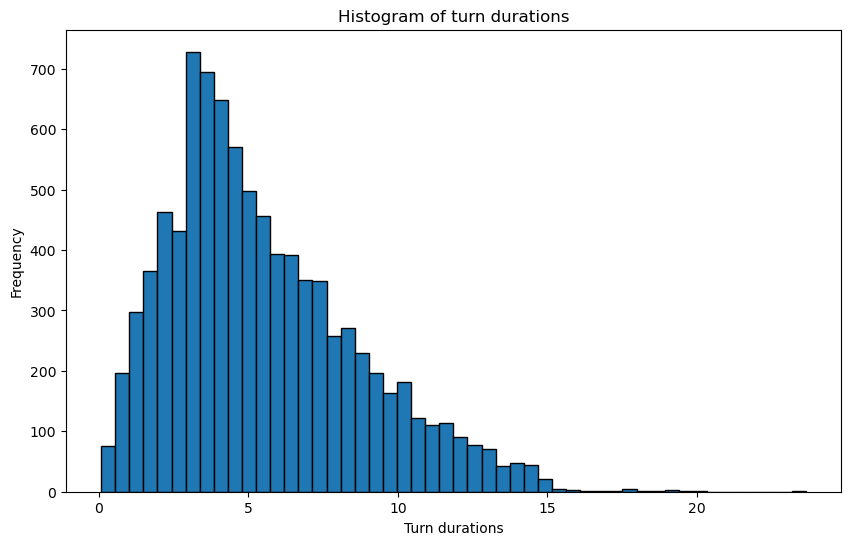

In [8]:
plt.figure(figsize=(10,6))
plt.hist(df['duration'], bins=50, edgecolor='black')
plt.title('Histogram of turn durations')
plt.xlabel('Turn durations')
plt.ylabel('Frequency')
plt.show()

Total entries: 4694
Percentage of dataset:
0.5227753647399488


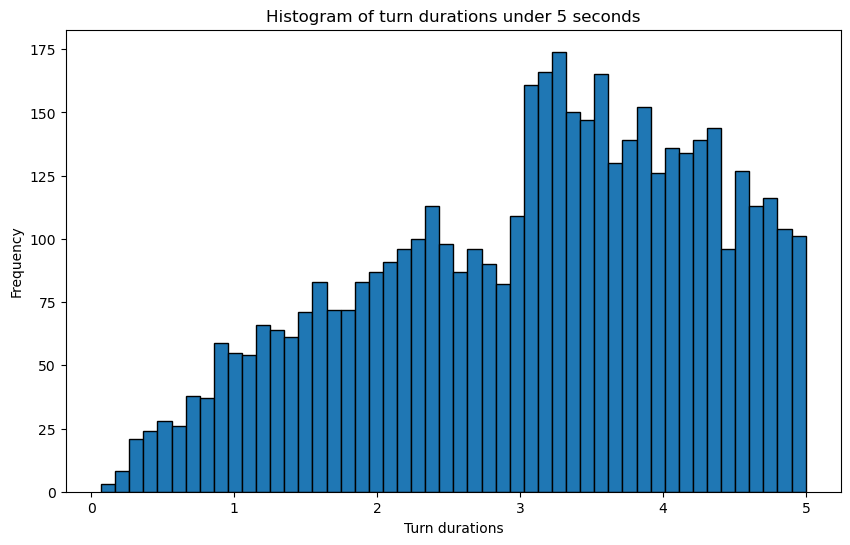

In [9]:
under5 = df.loc[df['duration'] < 5]
print("Total entries:", str(len(under5)))
print("Percentage of dataset:")
print(len(under5) / len(df))

plt.figure(figsize=(10,6))
plt.hist(under5['duration'], bins=50, edgecolor='black')
plt.title('Histogram of turn durations under 5 seconds')
plt.xlabel('Turn durations')
plt.ylabel('Frequency')
plt.show()

In [10]:
subset_maxduration_stats(df, 1)

Total entries: 266
Percentage of dataset:
2.962467980844192 %


In [11]:
subset_maxduration_stats(df, 2)

Total entries: 977
Percentage of dataset:
10.880944425882614 %


In [12]:
subset_minduration_stats(df, 20)

Total entries: 2
Percentage of dataset:
0.022274195344693173 %


In [13]:
subset_minduration_stats(df, 15)

Total entries: 26
Percentage of dataset:
0.28956453948101124 %


In [14]:
df.loc[df['duration'] >= 20]

,turn_name,duration,emotion,wav_path,transcription_path,alignment_path
900,Ses01M_impro02_M023_0,23.650,sad,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...
7726,Ses05F_script01_3_M016_0,20.142,exc,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...,D:/OneDrive - Universiteit Utrecht/Documents/0...


### I will finally be removing under 1 second turns and over 20 seconds ones, resulting in a loss of the 3% of the Dataset, but making the training more efficient and less prone to memory issues.